[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Dataset Shape: (1956, 2)
Class Distribution:
label
1    1005
0     951
Name: count, dtype: int64
Null Values in Dataset:
comment    0
label      0
dtype: int64
Feature Matrix Shape: (1956, 4180)
TF-IDF Matrix Shape: (1956, 4180)
Training Set Shape: (1467, 4180) 1467
Testing Set Shape: (489, 4180) 489
5-Fold Cross-Validation Scores: [0.86054422 0.89795918 0.88737201 0.81228669 0.8668942 ]
Mean CV Score: 0.8650112604768869

Test Accuracy: 0.8773006134969326
Confusion Matrix:
[[227  31]
 [ 29 202]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       258
           1       0.87      0.87      0.87       231

    accuracy                           0.88       489
   macro avg       0.88      0.88      0.88       489
weighted avg       0.88      0.88      0.88       489



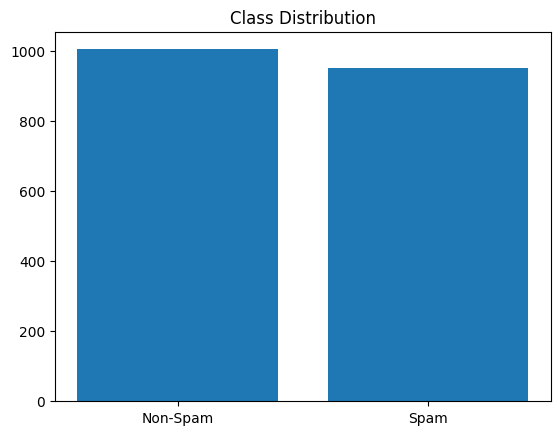


New Comments Classification Results:
Comment: This is such a wonderful video! Thank you for sharing your insights. Truly inspiring.
Prediction: Spam

Comment: Katy Perry's performance here is fantastic. Love the creativity in her work!
Prediction: Non-Spam

Comment: I can’t believe how much effort was put into this video. Dance was awesome!
Prediction: Non-Spam

Comment: This helped me understand the topic so much better. Your songs are amazing!
Prediction: Non-Spam

Comment: Win a free iPhone by clicking the link below! Don’t miss this amazing offer.
Prediction: Spam

Comment: Subscribe to my channel for exclusive content and free downloads!
Prediction: Spam



In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Step 1: Load the Data into a Pandas DataFrame
datasets = [
    "/content/sample_data/Youtube01-Psy.csv",
    "/content/sample_data/Youtube02-KatyPerry.csv",
    "/content/sample_data/Youtube03-LMFAO.csv",
    "/content/sample_data/Youtube04-Eminem.csv",
    "/content/sample_data/Youtube05-Shakira.csv",
]

# Load all datasets into a single DataFrame
data = pd.concat([pd.read_csv(file)[['CONTENT', 'CLASS']] for file in datasets], ignore_index=True)
data.columns = ['comment', 'label']  # Rename columns for consistency

# Step 2: Data Exploration
print("Dataset Shape:", data.shape)
print("Class Distribution:")
print(data['label'].value_counts())
print("Null Values in Dataset:")
print(data.isnull().sum())

# Step 3: Preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = data['comment'].apply(preprocess_text)

# Step 4: Feature Extraction
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_text'])
y = data['label']

print("Feature Matrix Shape:", X.shape)

# Apply TF-IDF Transformation
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

print("TF-IDF Matrix Shape:", X_tfidf.shape)

# Step 5: Shuffle the Dataset
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract Features and Labels from Shuffled Data
X = tfidf_transformer.transform(vectorizer.transform(shuffled_data['processed_text']))
y = shuffled_data['label']

# Step 6: Split the Dataset
split_index = int(0.75 * len(y))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Training Set Shape:", X_train.shape, len(y_train))
print("Testing Set Shape:", X_test.shape, len(y_test))

# Step 7: Train Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Step 8: Cross-validate the Model
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print("5-Fold Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Step 9: Test the Model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\nTest Accuracy:", accuracy)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize Class Distribution
plt.bar(['Non-Spam', 'Spam'], data['label'].value_counts())
plt.title('Class Distribution')
plt.show()


# Step 10: Test the classifier with six new comments
new_comments = [
   "This is such a wonderful video! Thank you for sharing your insights. Truly inspiring.",  # Non-Spam
    "Katy Perry's performance here is fantastic. Love the creativity in her work!",  # Non-Spam
    "I can’t believe how much effort was put into this video. Dance was awesome!",  # Non-Spam
    "This helped me understand the topic so much better. Your songs are amazing!",  # Non-Spam
    "Win a free iPhone by clicking the link below! Don’t miss this amazing offer.",  # Spam
    "Subscribe to my channel for exclusive content and free downloads!",  # Spam
]

# Preprocess the new comments
new_comments_processed = [preprocess_text(comment) for comment in new_comments]

# Transform the comments using the trained vectorizer and TF-IDF transformer
new_comments_vectorized = tfidf_transformer.transform(vectorizer.transform(new_comments_processed))

# Predict labels for the new comments
new_predictions = clf.predict(new_comments_vectorized)

# Display the results
print("\nNew Comments Classification Results:")
for comment, label in zip(new_comments, new_predictions):
    print(f"Comment: {comment}")
    print(f"Prediction: {'Spam' if label == 1 else 'Non-Spam'}\n")